# Features Selection (Rossmann Store Sales)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

In [2]:
#set display format of output from pandas
pd.set_option('display.float_format', lambda x: '%.6f' % x)
#extend chunksize for somes scatter plot
plt.rcParams['agg.path.chunksize'] = 10000

In [3]:
data_types = {
         'Id': np.dtype(int),
         'Store': np.dtype(int),
         'DayOfWeek': 'category',
         #'Date': np.dtype(str), # we will parse it later
         'Sales': np.dtype(int),
         'Customers': np.dtype(int),
         'Open': 'category',
         'Promo': 'category',
         'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(str)
         }

store_data_types = {
         'Store': np.dtype(int),
         'StoreType': np.dtype(str),
         'Assortment': np.dtype(str),
         'CompetitionDistance': np.dtype('float64'), # to prevent parsing null value
         'CompetitionOpenSinceMonth': np.dtype(str),
         'CompetitionOpenSinceYear': np.dtype(str),
         'Promo2': 'category',
         'Promo2SinceWeek': np.dtype(str),
         'Promo2SinceYear': np.dtype(str),
         'PromoInterval': np.dtype(str)
        }

train = pd.read_csv('input/train.csv', parse_dates=[2], dtype=data_types)
test = pd.read_csv('input/test.csv', parse_dates=[3], dtype=data_types)
store = pd.read_csv('input/store.csv', dtype=store_data_types)

In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [6]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.000000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000000,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.000000,4,2015,0,NaN,NaN,NaN


In [7]:
# train data
# remove the row that shops are closed
train = train[train["Open"] != '0']

In [8]:
# Merge with store data
train = pd.merge(train, store, on='Store')

## Add additional features

In [9]:
# Add is Competition
# This feature is to check that on the day of sales on each store will have the competition store openned or not.

SalesAndCompetition = train[['Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
train['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')


In [10]:
# Add is Promo2
# This feature is to check that on the day of sales on each store will adapt the promotion in that month or not.

SalesAndPromo2 = train[['Date','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']]
SalesAndPromo2 = SalesAndPromo2.fillna({'Promo2SinceYear': '9999', 'Promo2SinceWeek': '99', 'PromoInterval': 'None'})
train['isPromo2'] = np.where((SalesAndPromo2.Date.dt.year >= SalesAndPromo2['Promo2SinceYear'].astype(int)) &
                             (SalesAndPromo2.Date.dt.week >= SalesAndPromo2['Promo2SinceWeek'].astype(int))
                             , '1', '0')
train['isPromo2'] = train.apply(lambda x: '1' if x.isPromo2 != '0' and calendar.month_abbr[x.Date.month] in x.PromoInterval else '0', axis=1)



In [11]:
# Extract Year Month Day and WeekOfYear

train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

In [12]:
# Transform category values to be integer value

train.loc[train['StateHoliday'] == 'a', 'StateHoliday'] = '1'
train.loc[train['StateHoliday'] == 'b', 'StateHoliday'] = '2'
train.loc[train['StateHoliday'] == 'c', 'StateHoliday'] = '3'
train['StateHoliday'] = train['StateHoliday'].astype(int)

In [13]:
# Transform category values to be integer value

train.loc[train['StoreType'] == 'a', 'StoreType'] = '1'
train.loc[train['StoreType'] == 'b', 'StoreType'] = '2'
train.loc[train['StoreType'] == 'c', 'StoreType'] = '3'
train.loc[train['StoreType'] == 'd', 'StoreType'] = '4'
train['StoreType'] = train['StoreType'].astype(int)

In [14]:
# Transform category values to be integer value

train.loc[train['Assortment'] == 'a', 'Assortment'] = '1'
train.loc[train['Assortment'] == 'b', 'Assortment'] = '2'
train.loc[train['Assortment'] == 'c', 'Assortment'] = '3'
train['Assortment'] = train['Assortment'].astype(int)

In [15]:
# Some stores do not have competition so we will replace null value with 0 

train.CompetitionDistance.fillna(0, inplace=True)

In [16]:
# Select only some features to find the important features.
train = train[train["Open"] != 0]
train_data = train[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance','isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]
train_target = train[['Sales']]

In [17]:
train_data.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,isCompetition,isPromo2,Year,Month,Day,WeekOfYear
0,1,5,1,0,1,3,1,1270.000000,0,0,2015,7,31,31
1,1,4,1,0,1,3,1,1270.000000,0,0,2015,7,30,31
2,1,3,1,0,1,3,1,1270.000000,0,0,2015,7,29,31
3,1,2,1,0,1,3,1,1270.000000,0,0,2015,7,28,31
4,1,1,1,0,1,3,1,1270.000000,0,0,2015,7,27,31


## Feature importance with Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

Feature ranking:
1. feature Promo (0.688098)
2. feature DayOfWeek (0.160879)
3. feature WeekOfYear (0.047234)
4. feature Assortment (0.043709)
5. feature CompetitionDistance (0.030922)
6. feature Month (0.029159)
7. feature Day (0.000000)
8. feature Year (0.000000)
9. feature isPromo2 (0.000000)
10. feature isCompetition (0.000000)
11. feature StoreType (0.000000)
12. feature SchoolHoliday (0.000000)
13. feature StateHoliday (0.000000)
14. feature Store (0.000000)


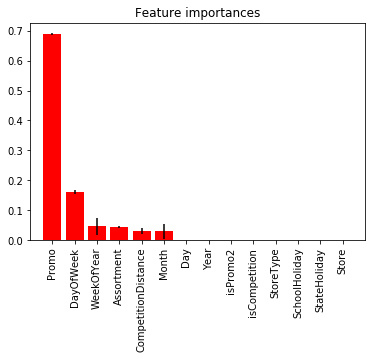

In [30]:
# Firstly we will try to use max_depth equal to 3 

forest = RandomForestRegressor(max_depth=3, n_estimators=10, random_state=0)

X = train_data
y = train_target
forest.fit(X, y.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), list(map(lambda x: X.columns[x], indices)), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Plot a Single Decision Tree from a Random Forest

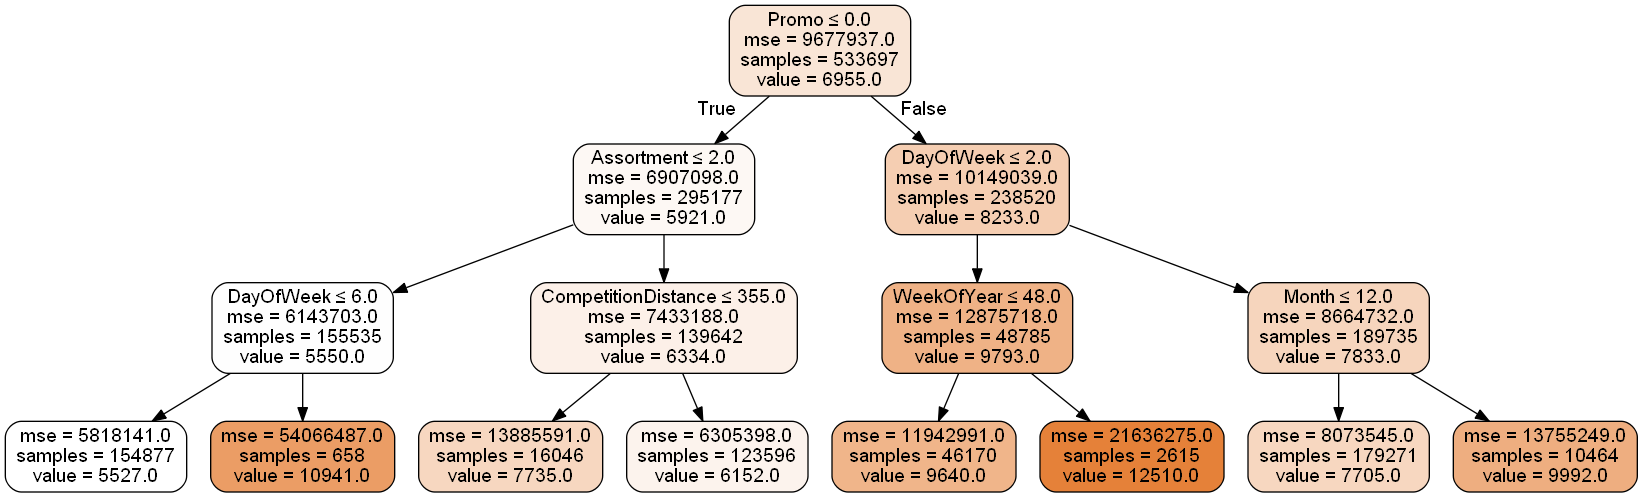

In [31]:
# We can plot the result to be a single decistion tree.

tree1 = forest.estimators_[9]
dot_data = StringIO()
export_graphviz(tree1, out_file=dot_data,feature_names = list(X),
                filled=True, rounded=True, precision = 0,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Feature ranking:
1. feature Store (0.308725)
2. feature CompetitionDistance (0.279591)
3. feature Promo (0.135554)
4. feature DayOfWeek (0.061615)
5. feature StoreType (0.054834)
6. feature Day (0.044655)
7. feature WeekOfYear (0.040436)
8. feature Assortment (0.020117)
9. feature Month (0.017913)
10. feature Year (0.014513)
11. feature isCompetition (0.009501)
12. feature SchoolHoliday (0.006547)
13. feature isPromo2 (0.004393)
14. feature StateHoliday (0.001607)


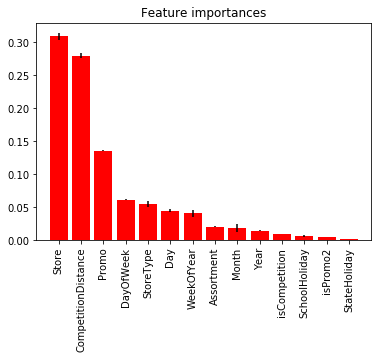

In [34]:
# Then we will try to optimize it

forest = RandomForestRegressor(n_estimators=10, random_state=0)

X = train_data
y = train_target
forest.fit(X, y.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), list(map(lambda x: X.columns[x], indices)), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

The most importance features are Promo, Competition Distance, Store, Day of Week, and StoreType

## Feature importance with Extra trees

Feature ranking:
1. feature CompetitionDistance (0.297520)
2. feature Store (0.293604)
3. feature Promo (0.135531)
4. feature DayOfWeek (0.060950)
5. feature StoreType (0.047653)
6. feature Day (0.036701)
7. feature WeekOfYear (0.032729)
8. feature Month (0.027524)
9. feature Assortment (0.018737)
10. feature isCompetition (0.016106)
11. feature Year (0.015271)
12. feature SchoolHoliday (0.008639)
13. feature isPromo2 (0.007490)
14. feature StateHoliday (0.001545)


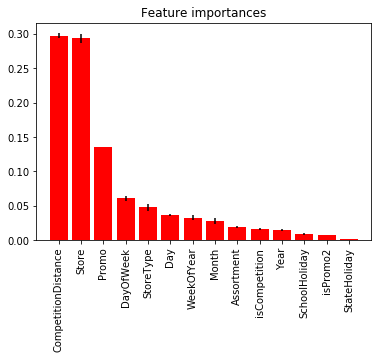

In [35]:
from sklearn.ensemble import ExtraTreesRegressor

forest = ExtraTreesRegressor(n_estimators=10, random_state=0)

X = train_data
y = train_target
forest.fit(X, y.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), list(map(lambda x: X.columns[x], indices)), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

The most importance features are Promo, DayOfWeek, StoreType, Competition Distance, Assortment